# **Welcome to the Demo Notebook (*In Progress*)**

In this demo notebook we go through the `.py` modules used for the project and demonstrate their functionality.<br>


### **Step 1) The Dependencies**


In [1]:
# Basic libraries
import re
import os
import gc
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
os.getcwd()

'/home/RDC/anasashb/Dokumente/DEDA_class_SoSe2023-main/DEDA_class_SoSe2023_LDA_MSc_Theses'

In [ ]:
# Install Requirements
pip install -r requirements.txt

### **Step 2) The Scraper**
Import the master_theses_scraper from the freshly added `thesis_scraper.py` module, docstring of which is given below. The function is constructed deliberately to produce many `print()` statements along the way to let the users know what stage of the work they are on and how this or that entry currently being processed looks like.

Also, to note, the scraping implementation is designed in a way that is specifically targeted at the HU website, meaning it will need some tinkering inside for repurposing. 


In [3]:
# Import the custom function and inspect
from thesis_scraper import master_theses_scraper 
master_theses_scraper?

Signature: master_theses_scraper(url, down_dir, headers)
Docstring:
Scrapes master's theses from a specified URL, retrieves download links, and downloads the theses.

Args:
    url (str): The URL of the webpage containing the LvB theses.
    down_dir (str): The directory where the scraped PDFs will be downloaded.
    headers (dict): HTTP headers to be used in the requests.
File:      ~/Dokumente/DEDA_class_SoSe2023-main/DEDA_class_SoSe2023_LDA_MSc_Theses/thesis_scraper.py
Type:      function

In [4]:
# Specify the link to scrape
url = 'https://www.wiwi.hu-berlin.de/de/forschung/irtg/lvb/research/dmb'

# Sets the directory for downloading our scraped pdfs
down_dir = 'OCRed PDFs/'

# Makes the directory in case it does not exist already
os.makedirs(down_dir, exist_ok = True)


# Set your own user agent here after ' User-Agent' Google: what is my user agent
headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:102.0) Gecko/20100101 Firefox/102.0',
    'Accept-Language': 'en-US'
}

In [5]:
# Run the function:
master_theses_scraper(url = url,
                      down_dir = down_dir,
                      headers = headers
)


Web page accessed.

244 entries found.

An example entry in our links container looks like:
 <a data-linktype="external" data-val="https://edoc.hu-berlin.de/handle/18452/24455" href="https://edoc.hu-berlin.de/handle/18452/24455">Comparing Cryptocurrency Indices to Traditional Indices</a>

Identifying invalid links...

51 invalid links identified.

193 entries remain.

Identifying Master's Theses...

124 Master's Theses identified.

A sample entry looks as follows:
 <a href="https://edoc.hu-berlin.de/handle/18452/23881">App-based Forecasting of CRIX Index Returns Using R and R-Shiny</a>

Retrieving download links...

Due to missing link, dropped entry: <a href="http://edoc.hu-berlin.de/master/ristig-alexander-2012-02-03">Modelling of Vector MEM with Hierarchical Archimedean Copula</a>

Due to missing link, dropped entry: <a href="http://edoc.hu-berlin.de/master/schelisch-martin-2011-06-10">Jumps in High Frequency Data</a>

Due to missing link, dropped entry: <a href="http://edoc.hu-ber

## **Step 3) Pre-Processing**

1. The first thing that needs to be done is to gather all English-language entries among our PDF files.
For this purpose, we have defined a function `en_detect` in the `lang_detect` module, which takes as argument our directory and the files inside, scans them and removes the non-English language entries (e.g. German entries).<br>

In [6]:
# Set folder as needed. 
folder = 'OCRed PDFs'
theses = os.listdir(folder) 


In [7]:
from lang_detect import en_detect
en_detect?

Signature: en_detect(folder=None, theses=None)
Docstring:
Goes through the scraped and downloaded PDF files and scans them to see if they are in English. 
This is necessary because some of the documents are in German (and some are unreadable).
To save memory, automatically selected to check pages 8, 12, 16, 20, 24; which should in all likelihood cases be body of text.
File:      ~/Dokumente/DEDA_class_SoSe2023-main/DEDA_class_SoSe2023_LDA_MSc_Theses/lang_detect.py
Type:      function

In [8]:
english_list = en_detect(folder, theses)


Current working directory: /home/RDC/anasashb/Dokumente/DEDA_class_SoSe2023-main/DEDA_class_SoSe2023_LDA_MSc_Theses

Currently working on 4.master_hauesler_konstantin.pdf_2021-03-05.pdf.

4.master_hauesler_konstantin.pdf_2021-03-05.pdf was identified as English.

Currently working on 34.weber.pdf_2015-12-09.pdf.

34.weber.pdf_2015-12-09.pdf was identified as English.

Currently working on 7.master_matic_jovanka.pdf_2020-06-24.pdf.

7.master_matic_jovanka.pdf_2020-06-24.pdf was identified as English.

Currently working on 49.bommes.pdf_2015-03-01.pdf.

49.bommes.pdf_2015-03-01.pdf was identified as English.

Currently working on 9.master_uenal_cemre.pdf_2019-08-13.pdf.

9.master_uenal_cemre.pdf_2019-08-13.pdf was identified as English.

Currently working on 10.Masterarbeit_Bricke_Thomas.pdf_2019-06-27.pdf.

10.Masterarbeit_Bricke_Thomas.pdf_2019-06-27.pdf removed from directory.

Currently working on 45.zhang.pdf_2015-03-31.pdf.

45.zhang.pdf_2015-03-31.pdf was identified as English.



In [41]:
# Clean memory
import gc
gc.collect()

531707

With $10$ papers dropped, that leaves the amount of  papers at $122$, decreased from the original $121$ scraped and additional $11$ sourced from CDs and scanning the physical documents.

*Note:* We additionally (manually) drop `118.su` because it kept crashing the function at any pc we ran it from. We also manually cropped `113.aydinli` in half since half of the papers was code.

In the end we have $121$ papers.

2. Now we move on to the preprocessing part using the function `preprocess_text` from text_prep.py

What does the function do?

For every document in our directory it:
- makes text lower case
- removes non alphabetic characters
- removes stop words
- removes single-character words and other possible PDF reading mistakes
- lemmatizes words
- renders the processed theses as `.txt` files

This helps significantly reduce dimensions and get rid of noise in our data.

**Additional Functionality (Somewhat Costly):**

We have further included additional, but fairly computationally costly, funcitionality within the function that can be turned on by setting argument `verbose = True`.

Using this, the function will save and count the word tokens at every stage of the preprocessing and automately generate plots for additional insight into the dimensionality reduction process.


In [10]:
# Import function
from text_prep import preprocess_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/RDC/anasashb/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /home/RDC/anasashb/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/RDC/anasashb/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/RDC/anasashb/nltk_data...


In [11]:
# See function arguments
preprocess_text?

Signature:
preprocess_text(
    first_input_folder=None,
    theses=None,
    inter_output_folder=None,
    verbose=False,
)
Docstring:
Preprocesses the PDF files by making everything lowercase,
getting rid of non-alphabetic words, removing stopwords,
tokenizing, lemmatizing, removing words with less than 3 character.

Args:
    first_input_folder (str): Path to the folder containing the PDF files.
    
    theses: os.listdir(folder).
            
    inter_output_folder (str): Intermediate output folder to save the filtered theses.
            
    verbose (bool): Returns vizualizations and information about dimensionality reduction. Can be set to False to save computational power, memory and time when working with large corpora of files.

Returns:
    None. Filthered theses saved in new folder.
File:      ~/Dokumente/DEDA_class_SoSe2023-main/DEDA_class_SoSe2023_LDA_MSc_Theses/text_prep.py
Type:      function

In [12]:
# Set folders as needed. 
first_input_folder = 'OCRed PDFs'
theses = os.listdir(first_input_folder) 
inter_output_folder = 'Filtered Theses'
os.makedirs(inter_output_folder, exist_ok = True)


Current working directory: /home/RDC/anasashb/Dokumente/DEDA_class_SoSe2023-main/DEDA_class_SoSe2023_LDA_MSc_Theses

Currently working on 4.master_hauesler_konstantin.pdf_2021-03-05.pdf.

Currently working on 34.weber.pdf_2015-12-09.pdf.

Currently working on 7.master_matic_jovanka.pdf_2020-06-24.pdf.

Currently working on 49.bommes.pdf_2015-03-01.pdf.

Currently working on 9.master_uenal_cemre.pdf_2019-08-13.pdf.

Currently working on aydinli cropped_2004-07-15.pdf.

Currently working on 45.zhang.pdf_2015-03-31.pdf.

Currently working on 13.master_pulec_vojtech.pdf_2019-02-25.pdf.

Currently working on 14.master_pulec_vojtech.pdf_2019-02-25.pdf.

Currently working on 15.masterarbeit_mitkov_ivan.pdf_2019-02-06.pdf.

Currently working on 35.steck.pdf_2015-12-09.pdf.

Currently working on 18.master_keilbar_georg.pdf_2018-08-03.pdf.

Currently working on 19.master_pollack_david.pdf_2018-06-29.pdf.

Currently working on 20.master_kolesnikova_alisa.pdf_2018-07-13.pdf.

Currently working on 

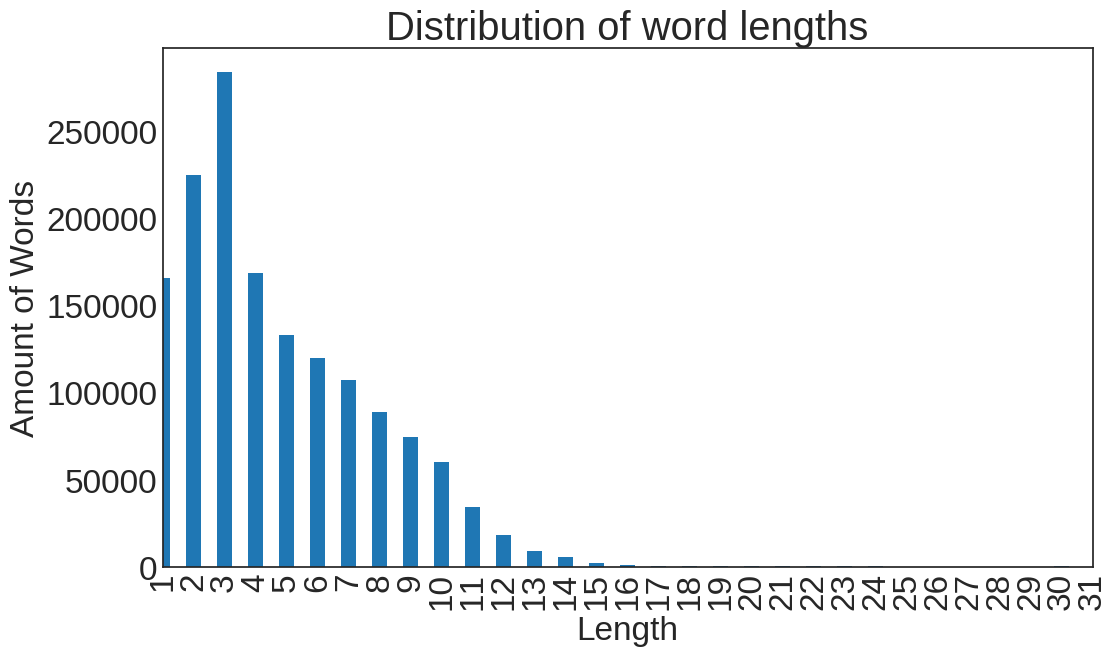


Total amount of words before dropping single character words: 1514969 


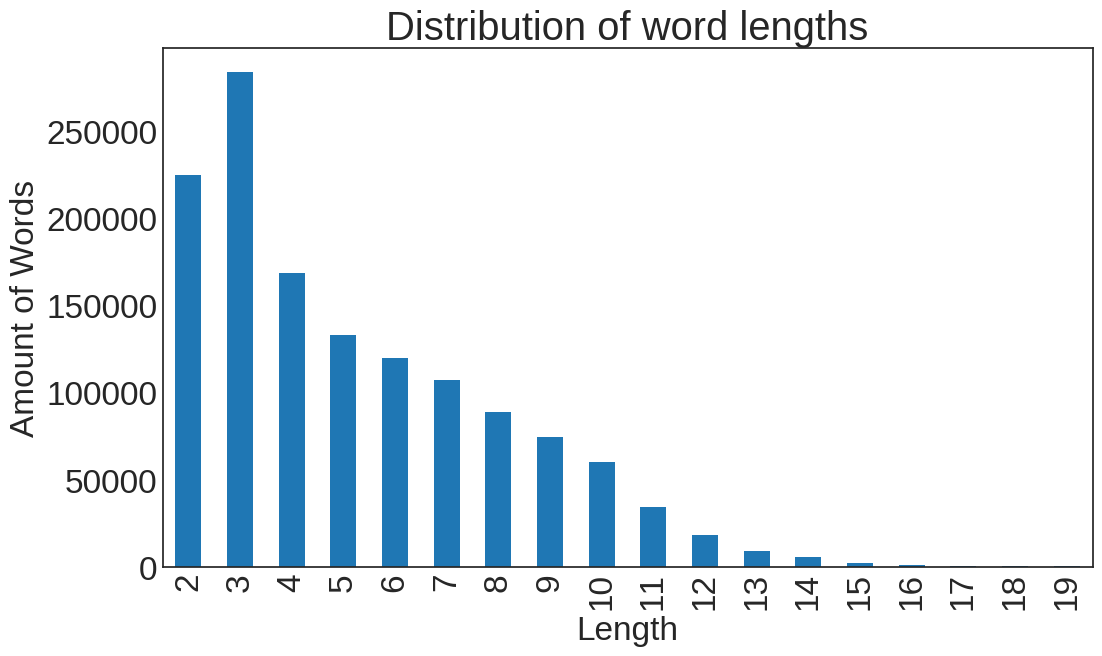


Total amount of words after dropping single character words and other pdf reader mistakes: 1336137 


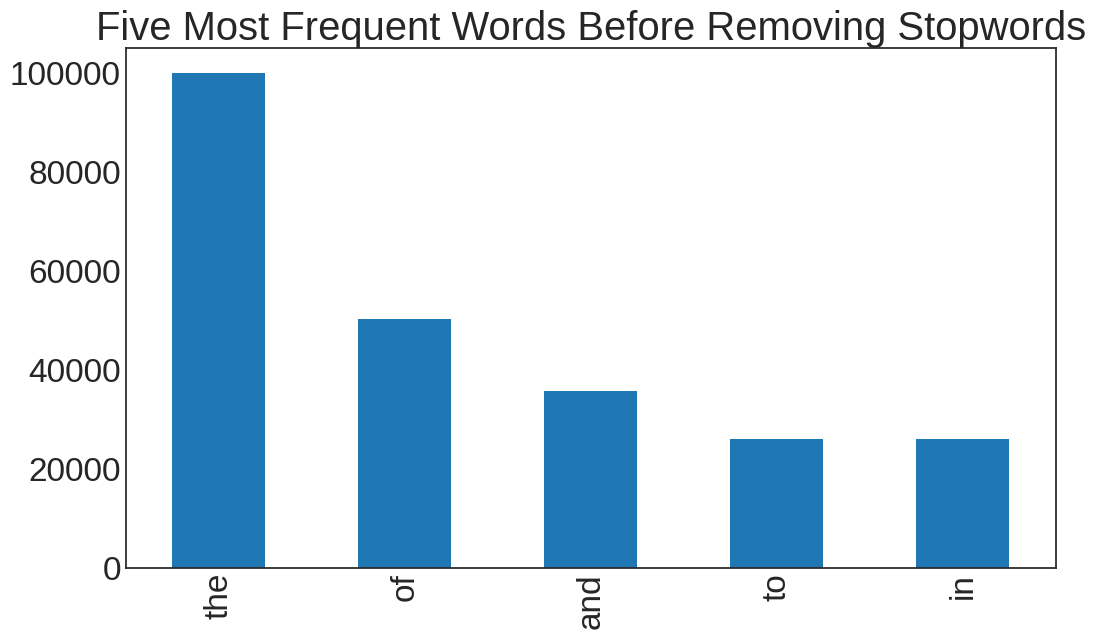


Total amount of words before removing stopwords: 1336137


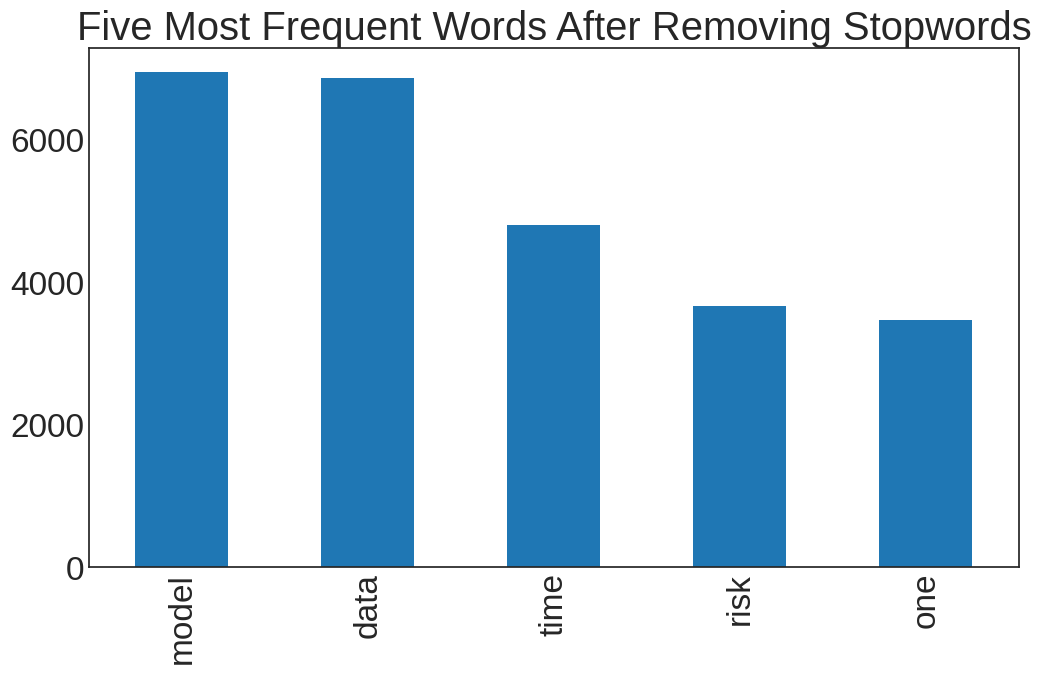


Total amount of words after removing stopwords: 823030


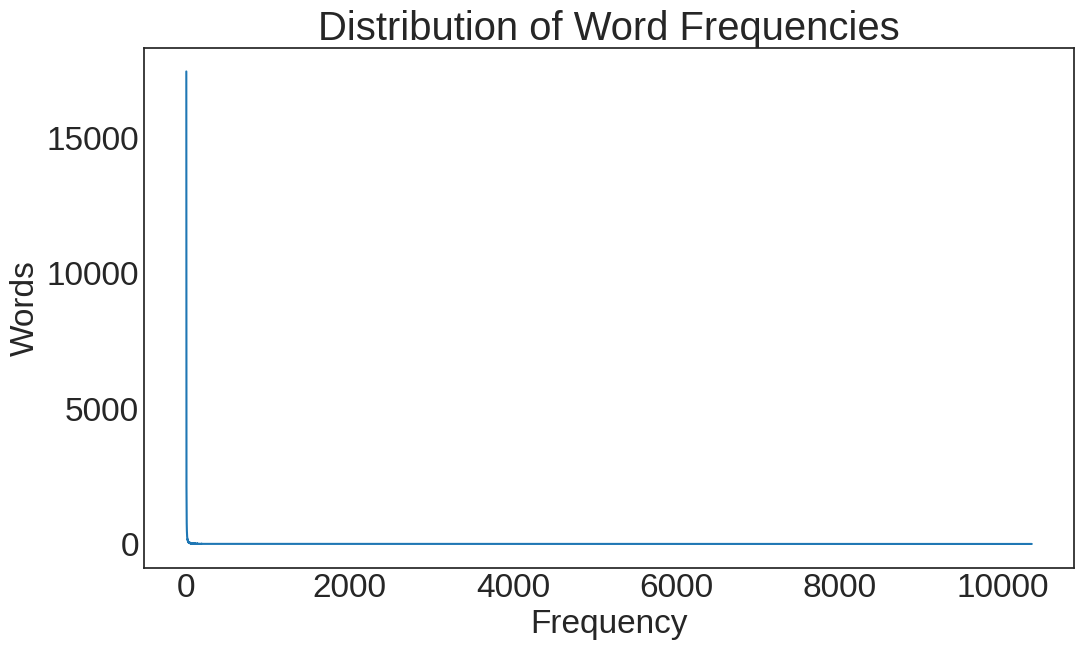

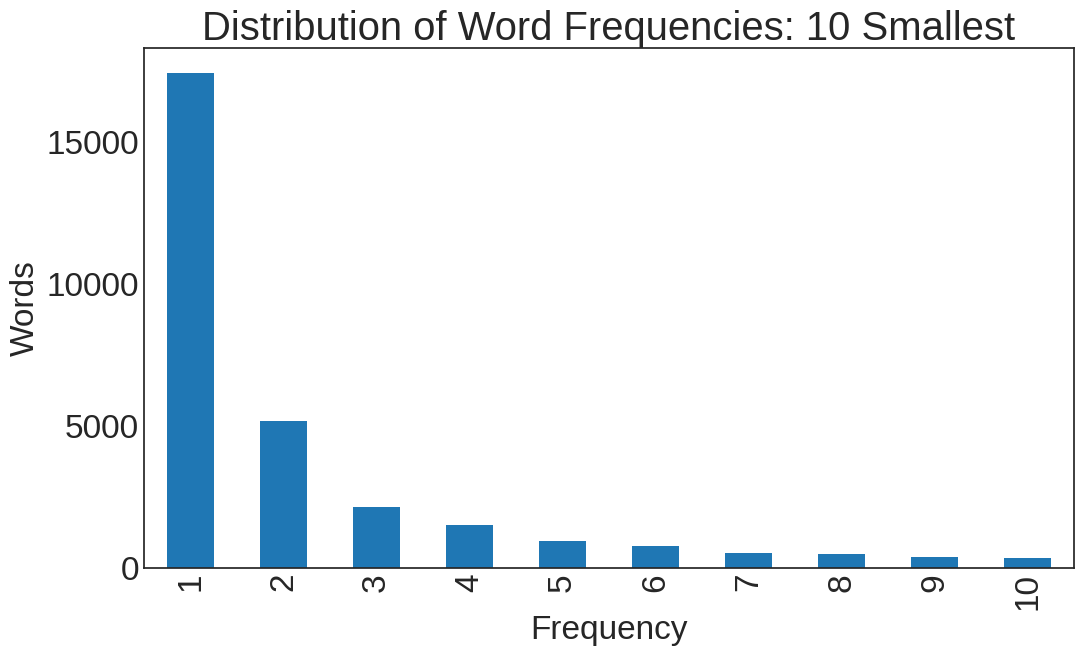




Preprocessing succesfully completed.



In [13]:
preprocess_text(first_input_folder, theses, inter_output_folder, verbose = True)


## Step 4) Making the corpus

For this we use the customly designed  `CorpusMaker` class, which includes three methods.

```python

CorpusMaker.make_corpus: 'Sets up the corpus, returns corpus, dictionary, ID mapping and texts. The returns are pickled and automatically saved to folder DICT_CORP.'
CorpusMaker.show_top_words: 'Prints selected amount of most frequent words per thesis.'
CorpusMaker.make_wordcloud: 'Generates word cloud image. The image is automatically saved to the Plots folder.'


In [2]:
# Import the class
from corpus_maker import CorpusMaker

In [3]:
# Inspect the class
CorpusMaker?

Init signature: CorpusMaker(input_folder)
Docstring:     
A class used for turning the filtered LvB MSc theses into a corpus. Generally, this class can also be used to generate a corpus from any set of .txt files that have already gone through standard NLP preprocessing. 

Outputs are saved as pickle files in automatically generated folder DICT_CORP.

Args:
    input_folder (str): The folder containing the filtered MSc theses. (Should set to the output of the preprocessing function)
    
Attributes:
    dictionary: A dictionary generated using Gensim.
    dictionary_token2id: A mapping of tokens to IDs.
    corpus: BoW corpus generated from the theses. 
    texts: All tokens (used for coherence later on)
    dates: Returns dates list for theses
    
Methods:
    make_corpus: Processes the filtered theses texts, drops rare words overall, creates corpus.
    show_top_words: Prints the most frequent words per thesis in the corpus
    make_wordcloud: Generates a wordcloud image from the co

In [4]:
corp_maker = CorpusMaker(input_folder = 'Filtered Theses')

In [5]:
dictionary, dictionary_token2id, corpus, texts, dates = corp_maker.make_corpus()


Creating corpus...

After removing 27770 rare words, total amount of words in the preprocessed texts decreased from 820804 to 793034

Corpus succesfully created.


In [6]:
corp_maker.show_top_words(amount = 5)


Thesis 1

estimate: 144

price: 126

bandwidth: 124

use: 107

option: 91


Thesis 2

portfolio: 155

return: 152

mean: 136

variance: 130

frontier: 126


Thesis 3

network: 165

function: 159

set: 81

neural: 75

neuron: 65


Thesis 4

learn: 111

md: 70

fic: 61

process: 54

booklet: 54


Thesis 5

course: 157

factor: 122

variable: 100

data: 87

student: 86


Thesis 6

md: 132

excel: 124

rex: 115

add: 96

statistical: 76


Thesis 7

function: 219

basis: 151

data: 132

spline: 129

use: 88


Thesis 8

function: 120

evalarg: 118

functional: 98

matrix: 86

coef: 86


Thesis 9

model: 250

option: 181

price: 156

hedge: 130

volatility: 125


Thesis 10

distribution: 130

density: 123

ic: 108

var: 96

estimate: 83


Thesis 11

tree: 175

data: 91

node: 91

decision: 64

class: 62


Thesis 12

model: 138

time: 94

iv: 93

one: 90

function: 80


Thesis 13

copula: 215

distribution: 91

portfolio: 47

function: 42

risk: 41


Thesis 14

copula: 259

parameter: 175

pa

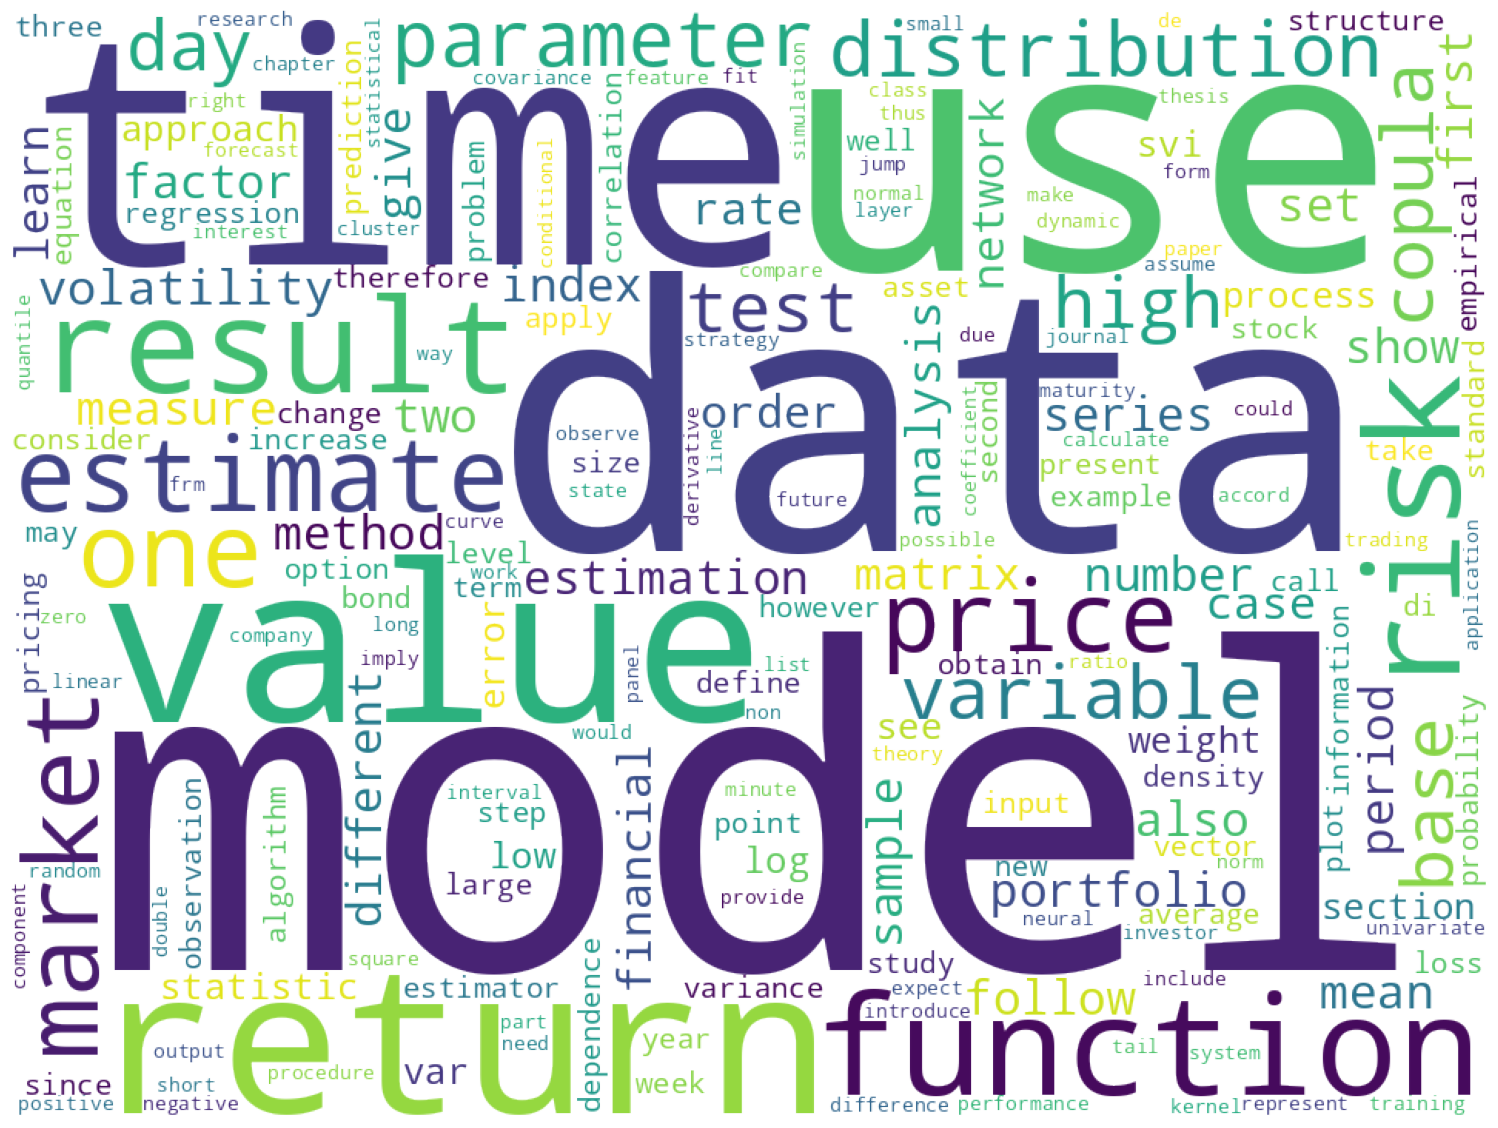

In [8]:
corp_maker.make_wordcloud()

## Step 5) LDA Class

We have defined a custom LDA class `LDA`, aimed at designing a simple,  user-friendly interface for carrying out LDA with grid search. 

As arguments, it takes `corpus`, `dictionary`, `texts` generated by the `CorpusMaker` class.

The class includes five methods:

```python

LDA.simple_fit(): 'Fits an LDA model with user\'s specifications.'
LDA.gird_search(): 'Carries out a grid search per user\'s specified parameters.'
LDA.lineplot_scores(): 'Plots coherence and perplexity scores per alpha and beta values and topic numbers.'
LDA.build_best_model(): 'Fits the best model obtained in grid search.'
LDA.viz(): 'Visualizes model obtained by either simple_fit or build_best_model methods.'
LDA.time_slicer(): 'Pre-processes the master\'s theses years as input for the sequential model.'
LDA.DTM(): 'Builds sequential model.'


In [9]:
from LDA_with_Grid import LDA

In [10]:
LDA?

Init signature: LDA(corpus, dictionary, texts, dates)
Docstring:     
A custom LDA interface designed to carry out a grid search, find the best model and vizualize it. 
Grid search carried out per coherence instead of perplexity, as optimizing for the latter may not lead to "human interpretable topics."

Args:

    corpus: A bag of words corpus (Already generated by CorpusMaker)
    dictionary: A gensim dictionary (Already generated by CorpusMaker)
    texts: All tokens (Already generated by CorpusMaker)
    
How to use:
    
    MSc_LDA = LDA(corpus, dictionary, texts) <-- initializes the class
    m = MSc_LDA.simple_fit() <-- fits one model with custom specs
    MSc_LDA.grid_search(n_topics, alphas, betas) <-- conducts grid search
    MSc_LDA.lineplot_scores() <-- plots coherence scores from grid search rounds
    m = MSc_LDA.build_best_model() <-- fits best model
    MSc_LDA.viz() <-- vizualizes best/simple model
    bes
File:           ~/Dokumente/DEDA_class_SoSe2023-main/DEDA_clas

### Using the `.simple_fit()`

*Note:* It is possible to run the code below directly by opening the pickled files with the code, essentially skipping the scraping and automated, as well as manual pre-processing steps.

```python
import pickle

with open('DICT_CORP/corpus.pkl', 'rb') as file:
    corpus = pickle.load(file)
    
with open('DICT_CORP/dictionary_token2id.pkl', 'rb') as file:
    dictionary_token2id = pickle.load(file)
    
with open('DICT_CORP/dictionary.pkl', 'rb') as file:
    dictionary = pickle.load(file)
    
with open('DICT_CORP/texts.pkl', 'rb') as file:
    texts = pickle.load(file)


In [4]:
# Copy the code here if needed to pick up where left off
import pickle

with open('DICT_CORP/corpus.pkl', 'rb') as file:
    corpus = pickle.load(file)
    
with open('DICT_CORP/dictionary_token2id.pkl', 'rb') as file:
    dictionary_token2id = pickle.load(file)
    
with open('DICT_CORP/dictionary.pkl', 'rb') as file:
    dictionary = pickle.load(file)
    
with open('DICT_CORP/texts.pkl', 'rb') as file:
    texts = pickle.load(file)

with open('DICT_CORP/dates.pkl', 'rb') as file:
    dates = pickle.load(file)

In [12]:
# Initialize
MSc_LDA = LDA(corpus, dictionary, texts, dates)

In [13]:
# Set up a single model with ten topics, alpha of 
n_top = 10
alpha_val = 'symmetric'
beta_val = 0.6

simple_m = MSc_LDA.simple_fit(n_top = n_top,
                             alpha_val = alpha_val,
                             beta_val = beta_val)


Coherence Score is: 0.4249070901873311

Perplexity Score is: -7.57871930856154

See the topics:
(0, '0.014*"model" + 0.011*"data" + 0.010*"use" + 0.010*"sentiment" + 0.008*"base" + 0.008*"time" + 0.007*"network" + 0.007*"learn" + 0.006*"word" + 0.006*"input"')
(1, '0.021*"factor" + 0.017*"return" + 0.012*"market" + 0.012*"model" + 0.011*"risk" + 0.009*"asset" + 0.007*"time" + 0.007*"cryptocurrency" + 0.006*"network" + 0.006*"data"')
(2, '0.015*"model" + 0.012*"variable" + 0.010*"data" + 0.008*"use" + 0.007*"company" + 0.007*"tree" + 0.005*"success" + 0.005*"regression" + 0.005*"funding" + 0.005*"startup"')
(3, '0.017*"data" + 0.009*"value" + 0.006*"analysis" + 0.006*"feature" + 0.005*"model" + 0.005*"area" + 0.005*"price" + 0.005*"spatial" + 0.005*"method" + 0.005*"regression"')
(4, '0.016*"portfolio" + 0.011*"data" + 0.010*"copula" + 0.009*"cluster" + 0.008*"distribution" + 0.008*"risk" + 0.008*"model" + 0.008*"return" + 0.007*"factor" + 0.007*"use"')
(5, '0.023*"frm" + 0.014*"risk" 

In [15]:
# Vizualize model
MSc_LDA.viz(model_type = 'simple') 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.068980 -0.023233       1        1  20.337568
9      0.052149 -0.064692       2        1  17.183061
0     -0.023344  0.011293       3        1  12.483618
7      0.067764 -0.005781       4        1  12.327559
2      0.009679  0.060380       5        1  10.369979
3     -0.031428  0.117982       6        1   7.504830
5      0.043347 -0.078039       7        1   6.598894
6      0.022169  0.100568       8        1   6.055308
1      0.012362 -0.069885       9        1   3.864290
8     -0.221679 -0.048594      10        1   3.274892, topic_info=        Term         Freq        Total Category  logprob  loglift
3316     frm  1233.000000  1233.000000  Default  30.0000  30.0000
1865  factor  2383.000000  2383.000000  Default  29.0000  29.0000
895     risk  3695.000000  3695.000000  Default  28.0000  28.0000
4475  copula  2011.000000  2011.000000  Default  27.0000  27.0000
886   return  3766.000000  3766.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
2702  system    98.712479   665.600950  Topic10  -5.5725   1.5104
517    index   103.437230  1727.592031  Topic10  -5.5258   0.6034
1097     use   113.240208  4951.653368  Topic10  -5.4352  -0.3591
801    price   103.438077  3445.564779  Topic10  -5.5258  -0.0870
886   return    97.300873  3766.414752  Topic10  -5.5869  -0.2372

[694 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1175      1  0.941241   ac
1175      2  0.001937   ac
1175      3  0.003873   ac
1175      4  0.011620   ac
1175      5  0.003873   ac
...     ...       ...  ...
6290      2  0.058709  yes
6290      4  0.023484  yes
6290      5  0.845413  yes
6290      6  0.011742  yes
6290      8  0.035226  yes

[4211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 1, 8, 3, 4, 6, 7, 2, 9])

### Using the `.grid_search()` and `.build_best_model()`


#### 1st iteration of the search

In [16]:

# Set up parameter grid 
#n_topics = list(range(2, 10))
#alphas = np.arange(0.1, 1, 0.2).tolist()
#betas = np.arange(0.1, 1, 0.2).tolist()
n_topics = range(2,30)
alpha = ['symmetric']
beta = ['auto']

## I append these two by hand to the gird
# because I'm not skilled enough to have included them in the upper lines of code
#alphas.append('symmetric')
#betas.append('auto')


**About the verbose argument:**

The verbose argument here just activates print statements that show the coherence score per round of the search. Even if set to false, the outputs will be saved as a CSV file. 

In [17]:
# Do the grid search
MSc_LDA.grid_search(n_topics, alpha, beta, verbose = True)

# Setting verbose = True ensures the function output 


Number of topics: 2; alpha: symmetric; beta: auto; Achieved coherence score: 0.34198770374602727

Number of topics: 3; alpha: symmetric; beta: auto; Achieved coherence score: 0.324431324777173

Number of topics: 4; alpha: symmetric; beta: auto; Achieved coherence score: 0.3736310468524897

Number of topics: 5; alpha: symmetric; beta: auto; Achieved coherence score: 0.36159288166464243

Number of topics: 6; alpha: symmetric; beta: auto; Achieved coherence score: 0.40017748268360814

Number of topics: 7; alpha: symmetric; beta: auto; Achieved coherence score: 0.3933500232530847

Number of topics: 8; alpha: symmetric; beta: auto; Achieved coherence score: 0.4195835701621671

Number of topics: 9; alpha: symmetric; beta: auto; Achieved coherence score: 0.43072943463967256

Number of topics: 10; alpha: symmetric; beta: auto; Achieved coherence score: 0.45340590685054705

Number of topics: 11; alpha: symmetric; beta: auto; Achieved coherence score: 0.43789510537071535

Number of topics: 12; 

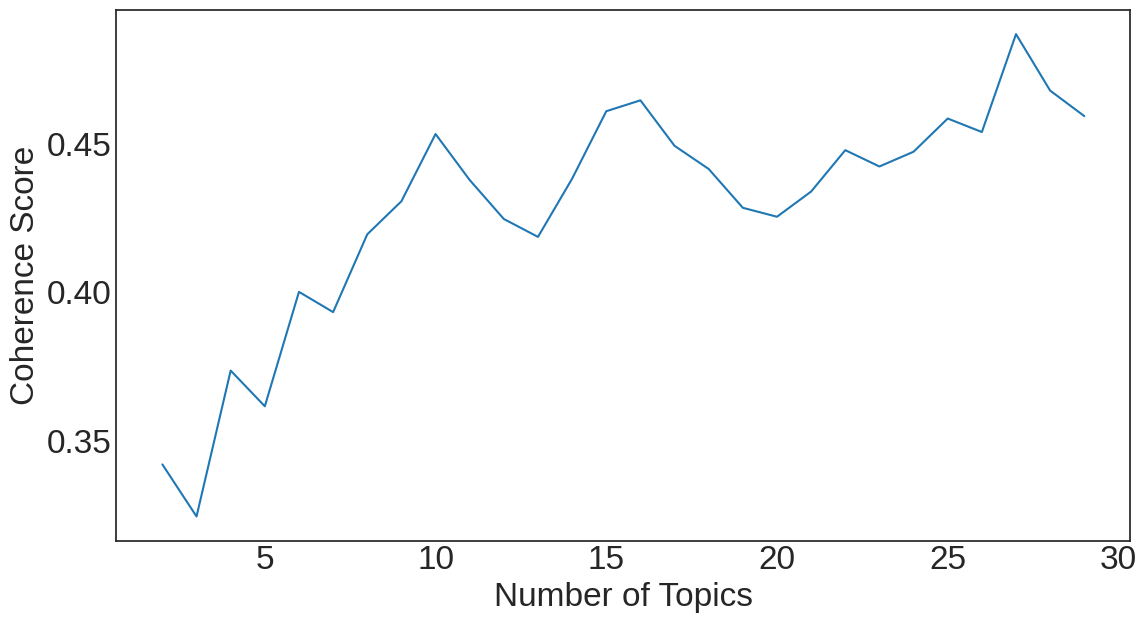

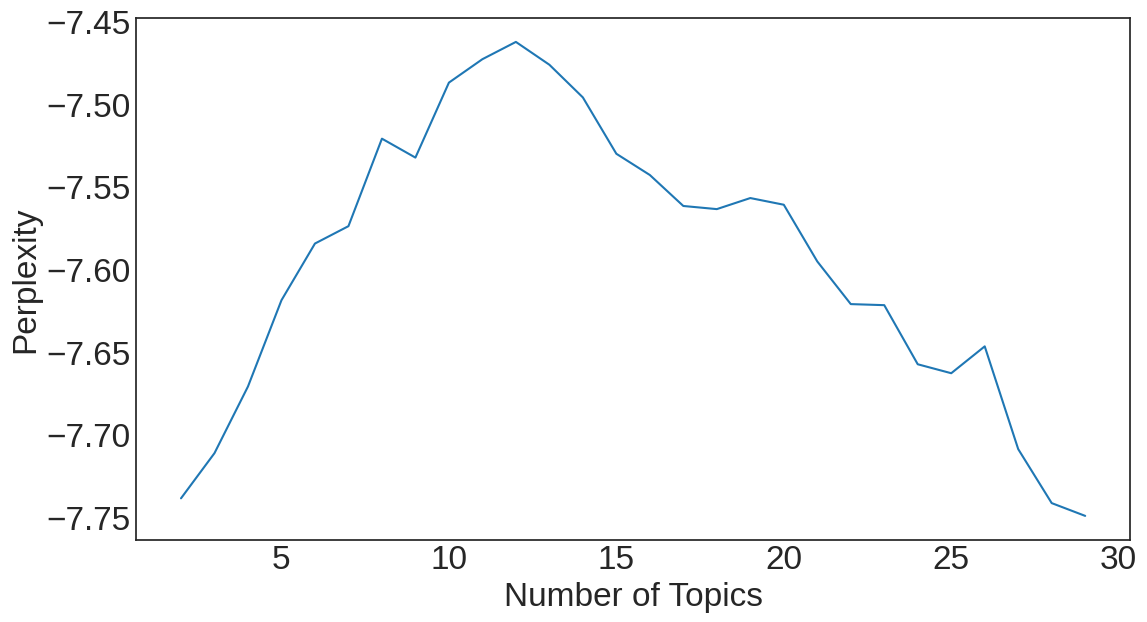

In [18]:
# Plot the scores
MSc_LDA.lineplot_scores()

In [19]:
# call best model
best_m = MSc_LDA.build_best_model()

(24, '0.020*"estimator" + 0.020*"model" + 0.019*"covariance" + 0.018*"realize" + 0.017*"volatility" + 0.017*"distribution" + 0.016*"inc" + 0.014*"matrix" + 0.014*"portfolio" + 0.012*"stock"')
(14, '0.013*"temperature" + 0.011*"use" + 0.011*"model" + 0.011*"ar" + 0.010*"var" + 0.009*"spatial" + 0.008*"landkreis" + 0.008*"country" + 0.008*"variable" + 0.007*"region"')
(26, '0.044*"svi" + 0.041*"day" + 0.038*"week" + 0.027*"model" + 0.020*"minute" + 0.020*"period" + 0.019*"di" + 0.016*"granularity" + 0.016*"learn" + 0.015*"univariate"')
(23, '0.035*"rate" + 0.030*"wealth" + 0.021*"kelly" + 0.018*"swap" + 0.016*"give" + 0.016*"time" + 0.015*"strategy" + 0.015*"trial" + 0.013*"forward" + 0.013*"mean"')
(13, '0.019*"data" + 0.011*"model" + 0.010*"feature" + 0.010*"order" + 0.009*"price" + 0.009*"time" + 0.007*"value" + 0.007*"prediction" + 0.006*"level" + 0.006*"use"')
(6, '0.043*"copula" + 0.029*"model" + 0.020*"cdo" + 0.017*"tranche" + 0.017*"correlation" + 0.015*"default" + 0.013*"csv" + 

In [20]:
# Viz best model by setting model_type = 'best'
MSc_LDA.viz(model_type = 'best')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.055066  0.009105       1        1  10.975008
3      0.012258 -0.036600       2        1   6.111763
13     0.029875 -0.136389       3        1   5.906396
22     0.075142  0.100674       4        1   5.784393
12     0.026124  0.094824       5        1   5.683985
15     0.038857 -0.137485       6        1   5.557747
9      0.071912  0.065295       7        1   5.546113
20     0.066131 -0.121006       8        1   4.927679
0      0.020077  0.157337       9        1   4.567308
26    -0.019282 -0.058036      10        1   4.278188
2      0.035294 -0.144361      11        1   4.220050
16     0.029465  0.040983      12        1   3.710669
25     0.005097  0.077985      13        1   3.556697
11     0.053785 -0.108404      14        1   3.484828
4      0.060489  0.005235      15        1   3.229010
24     0.038780  0.098474      16        1   3.181616
21     0.048116 -0.158347      17        1   2.860438
14     0.019490  0.059487      18        1   2.771867
17     0.122287 -0.008035      19        1   2.692407
7      0.093295 -0.012875      20        1   2.367471
5      0.109234  0.036191      21        1   2.203173
19    -0.015345  0.008402      22        1   1.870975
6     -0.068348  0.108212      23        1   1.686802
23    -0.072931  0.172868      24        1   1.416662
8     -0.228253 -0.053475      25        1   0.843043
10    -0.267819 -0.059108      26        1   0.498673
1     -0.338795 -0.000952      27        1   0.067040, topic_info=                 Term         Freq        Total Category  logprob  loglift
4475           copula  2816.000000  2816.000000  Default  30.0000  30.0000
1060             time  5036.000000  5036.000000  Default  29.0000  29.0000
736            option  1552.000000  1552.000000  Default  28.0000  28.0000
10516             svi  1503.000000  1503.000000  Default  27.0000  27.0000
3316              frm  1180.000000  1180.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
998             stock     7.284625  1353.342004  Topic27  -4.2902   2.0831
600            liquid     3.542807   123.440837  Topic27  -5.0111   3.7568
667             month     3.042776   391.327215  Topic27  -5.1632   2.4509
933    semiparametric     2.621016   138.374675  Topic27  -5.3124   3.3412
1315         deutsche     2.253249    69.061371  Topic27  -5.4636   3.8850

[1916 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
5206      17  0.808460  abnormal
5206      19  0.164218  abnormal
1175       1  0.003683        ac
1175       3  0.018415        ac
1175       6  0.014732        ac
...      ...       ...       ...
1172      17  0.011357        zu
1172      20  0.007572        zu
1172      23  0.011357        zu
11933      1  0.975481        zv
9660      14  0.811261  zwischen

[8484 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 4, 14, 23, 13, 16, 10, 21, 1, 27, 3, 17, 26, 12, 5, 25, 22, 15, 18, 8, 6, 20, 7, 24, 9, 11, 2])

#### 2nd iteration

In [21]:
# Set up parameter grid 

n_topics = [12]
alphas = np.arange(0.1, 1, 0.2).tolist()
betas = np.arange(0.1, 1, 0.2).tolist()

## I append these two by hand to the gird
# because I'm not skilled enough to have included them in the upper lines of code
alphas.append('symmetric')
betas.append('auto')

In [22]:
#remove the assigned best score from the previous iteration
MSc_LDA.best_score = -1

# Do the grid search
MSc_LDA.grid_search(n_topics, alphas, betas, verbose = True)

# Setting verbose = True ensures the function output 


Number of topics: 12; alpha: 0.1; beta: 0.1; Achieved coherence score: 0.42875795180974463

Number of topics: 12; alpha: 0.1; beta: 0.30000000000000004; Achieved coherence score: 0.45507143824669694

Number of topics: 12; alpha: 0.1; beta: 0.5000000000000001; Achieved coherence score: 0.44785493120549

Number of topics: 12; alpha: 0.1; beta: 0.7000000000000001; Achieved coherence score: 0.4496650058547567

Number of topics: 12; alpha: 0.1; beta: 0.9000000000000001; Achieved coherence score: 0.44259227044740435

Number of topics: 12; alpha: 0.1; beta: auto; Achieved coherence score: 0.42475014734765537

Number of topics: 12; alpha: 0.30000000000000004; beta: 0.1; Achieved coherence score: 0.42975198273614046

Number of topics: 12; alpha: 0.30000000000000004; beta: 0.30000000000000004; Achieved coherence score: 0.4570526099744527

Number of topics: 12; alpha: 0.30000000000000004; beta: 0.5000000000000001; Achieved coherence score: 0.44485664204894776

Number of topics: 12; alpha: 0.3000

In [23]:
# call best model
best_m = MSc_LDA.build_best_model()

(0, '0.016*"model" + 0.013*"time" + 0.012*"data" + 0.012*"network" + 0.010*"prediction" + 0.010*"layer" + 0.009*"order" + 0.009*"return" + 0.008*"learn" + 0.008*"price"')
(1, '0.013*"crypto" + 0.013*"function" + 0.011*"contract" + 0.010*"currency" + 0.010*"blockchain" + 0.009*"value" + 0.008*"smart" + 0.007*"token" + 0.007*"address" + 0.007*"coin"')
(2, '0.015*"model" + 0.012*"variable" + 0.010*"data" + 0.009*"use" + 0.007*"value" + 0.006*"test" + 0.006*"one" + 0.005*"result" + 0.005*"function" + 0.005*"set"')
(3, '0.013*"data" + 0.010*"function" + 0.009*"energy" + 0.008*"use" + 0.007*"inc" + 0.007*"consumption" + 0.006*"matrix" + 0.006*"may" + 0.006*"value" + 0.006*"error"')
(4, '0.022*"portfolio" + 0.015*"data" + 0.012*"cluster" + 0.008*"return" + 0.008*"weight" + 0.008*"distribution" + 0.008*"risk" + 0.008*"pc" + 0.008*"variance" + 0.007*"number"')
(5, '0.029*"frm" + 0.016*"risk" + 0.013*"private" + 0.012*"return" + 0.011*"equity" + 0.010*"financial" + 0.010*"test" + 0.009*"market" 

In [24]:
# Viz best model by setting model_type = 'best'
MSc_LDA.viz(model_type = 'best')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.002167  0.005164       1        1  19.398393
7     -0.065233  0.044982       2        1  16.035556
9     -0.061998  0.067980       3        1  11.606569
4     -0.100241  0.029926       4        1  10.094944
10     0.082912 -0.007587       5        1   7.565386
6     -0.103808  0.007057       6        1   7.019833
8     -0.039452 -0.205761       7        1   6.219094
3     -0.018774 -0.048715       8        1   6.019357
5     -0.055831  0.099495       9        1   4.913046
0      0.091761 -0.073656      10        1   4.484769
11     0.092839 -0.002323      11        1   3.826129
1      0.179994  0.083439      12        1   2.816922, topic_info=            Term         Freq        Total Category  logprob  loglift
4475      copula  2286.000000  2286.000000  Default  30.0000  30.0000
10516        svi  1348.000000  1348.000000  Default  29.0000  29.0000
3316         frm  1121.000000  1121.000000  Default  28.0000  28.0000
783    portfolio  2662.000000  2662.000000  Default  27.0000  27.0000
1133        week  1196.000000  1196.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
625       market   118.232558  4027.423176  Topic12  -5.2414   0.0413
875      require    77.567560   438.264653  Topic12  -5.6629   1.8379
1097         use   102.037387  5197.766542  Topic12  -5.3888  -0.3611
801        price    95.988128  3266.745056  Topic12  -5.4499   0.0422
886       return    88.777297  4313.485062  Topic12  -5.5280  -0.3138

[856 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5206      1  0.010974  abnormal
5206      2  0.395060  abnormal
5206      6  0.010974  abnormal
5206      7  0.010974  abnormal
5206      8  0.010974  abnormal
...     ...       ...       ...
1172      8  0.024482        zu
1172      9  0.016321        zu
1172     10  0.024482        zu
1172     11  0.016321        zu
1172     12  0.289700        zu

[4756 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 10, 5, 11, 7, 9, 4, 6, 1, 12, 2])

# Dynamic Topic Modelling

In [25]:
# Inspect the time slicer which will set up batches to be used in sequential modeling
MSc_LDA.time_slicer?

Signature: MSc_LDA.time_slicer(year_batches)
Docstring:
Takes a list of several year ranges and converts them into time slices as an input for dtm.

Args:
    year_batches: List of several year ranges
    dates: Input already Generated by CorpusMaker
Returns:
    time_slice: input for dtm
    
Example use:
    Set up variable: 
        year_batches = [range(2002,2009), range(2009,2016), range(2016, 2020), range(2020, 2024)]
    Run method:
        time_slicer(year_btaches)
File:      ~/Dokumente/DEDA_class_SoSe2023-main/DEDA_class_SoSe2023_LDA_MSc_Theses/LDA_with_Grid.py
Type:      method

In [26]:
year_batches = [range(2002,2009), range(2009,2016), range(2016, 2020), range(2020, 2024)]
MSc_LDA.time_slicer(year_batches)

[29, 50, 24, 18]

In [28]:
MSc_LDA.DTM?

Signature: MSc_LDA.DTM()
Docstring:
Builds a DTM model following the best parameters received from grid_search. Note: function will not work without conducting a grid search.

Args:
    time_slice: A list of how many documents are included in the chronological time slices. (Generated by time_slicer function)
    
Returns:
    Sequential model
File:      ~/Dokumente/DEDA_class_SoSe2023-main/DEDA_class_SoSe2023_LDA_MSc_Theses/LDA_with_Grid.py
Type:      method

In [40]:
temp_file = "LDAModels_Gensim/DTM_model.gensim"
ldaseq.save(temp_file)

# for given time, the distriibution of each topic 
ldaseq.print_topics(time=1)

[[('model', 0.014005542809530609),
  ('network', 0.013727063224986995),
  ('use', 0.009370530780721144),
  ('data', 0.009321309729269141),
  ('neural', 0.00802436365471924),
  ('learn', 0.007066621761689911),
  ('set', 0.006897894460576503),
  ('layer', 0.006617272845295547),
  ('time', 0.006549779036734894),
  ('input', 0.006306357741053037),
  ('training', 0.00592971957448906),
  ('function', 0.005883311084155509),
  ('sentiment', 0.005467196384846509),
  ('value', 0.005242372983374878),
  ('prediction', 0.005129163334561604),
  ('one', 0.005104539429949271),
  ('base', 0.0050270709433826955),
  ('output', 0.0048493610704385065),
  ('article', 0.004492384624635602),
  ('return', 0.004476717414125254)],
 [('model', 0.02663587830470165),
  ('copula', 0.018768173364739175),
  ('factor', 0.00865892221288575),
  ('correlation', 0.008488979857584508),
  ('data', 0.008237633697029777),
  ('item', 0.007267309926638484),
  ('cdo', 0.00707731017956711),
  ('default', 0.0060574108795701555),
  

In [85]:
# for given topic the word distribution over time
DTM_topics = []

for topic in range(0,MSc_LDA.best_params[0]):
    DTM_topics.append(ldaseq.print_topic_times(topic=topic, top_terms=30))

In [87]:
DTM_topics[0]

[[('model', 0.013830049244010718),
  ('network', 0.013754892866623113),
  ('use', 0.009312119710953451),
  ('data', 0.009206645248148872),
  ('neural', 0.009036702216094731),
  ('learn', 0.006986850414046119),
  ('input', 0.0069579057183607644),
  ('set', 0.006914153379902554),
  ('layer', 0.006765084544914878),
  ('time', 0.0064611402664899896),
  ('training', 0.006121848447713039),
  ('function', 0.005945358010493736),
  ('sentiment', 0.005263042275873614),
  ('value', 0.005213362990795907),
  ('article', 0.005082637508994419),
  ('prediction', 0.005022474020375296),
  ('one', 0.004976371482791058),
  ('base', 0.004914142911120125),
  ('output', 0.004844538563982004),
  ('return', 0.004379512877572182),
  ('word', 0.004106487115394596),
  ('error', 0.0039886927059324525),
  ('lstm', 0.003913374986358788),
  ('market', 0.0037822134610147043),
  ('price', 0.0037244682566931605),
  ('result', 0.0034583881707245987),
  ('weight', 0.003424126631719622),
  ('energy', 0.0033706842553237614)

In [88]:
import pandas as pd

#the same as year_batches but for greater looking visuals
#turns a batch from a list to a str "begin_year - end_year"
time_periods = [f"{period[0]}-{period[-1]}" for period in year_batches]

def topic_time(DTM_topic,time_periods):  
    dfs = []
    for period, topic_dist in enumerate(DTM_topic):
        df = pd.DataFrame(topic_dist, columns=["Word", f"Period {period+1}"])
        dfs.append(df)

    # Merge the DataFrames based on the "Word" column
    topic_words_time = pd.concat(dfs).groupby("Word").sum()

    # Fill NaN values with zeros
    topic_words_time.fillna(0, inplace=True)
    topic_words_time.columns = time_periods
    
    # Display the resulting DataFrame
    return topic_words_time

In [89]:
topics_words_time = []

for topic in DTM_topics:
    topics_words_time.append(topic_time(topic,time_periods))
    
topics_words_time[7]

,2002-2008,2009-2015,2016-2019,2020-2023
Word,,,,
address,0.006004,0.006108,0.006309,0.006544
asset,0.005754,0.005728,0.005867,0.005936
bitcoin,0.008398,0.008444,0.007949,0.006781
blockchain,0.007481,0.007741,0.008230,0.008714
coin,0.007545,0.007672,0.007865,0.008059
constituent,0.006213,0.006100,0.005852,0.005658
contract,0.009203,0.009354,0.009681,0.010025
crix,0.013204,0.013252,0.013165,0.013040
crypto,0.013261,0.014114,0.014608,0.013360


In [90]:
import os

# Create a directory for saving the CSV files
directory = "topics_words_time"
if not os.path.exists(directory):
    os.makedirs(directory)

# Iterate over each element in topics_words_time
for i, df in enumerate(topics_words_time):
    # Generate the file path for the current topic
    file_path = os.path.join(directory, f"topic{i+1}_words_time.csv")

    # Save the dataframe as a CSV file
    df.to_csv(file_path)

In [114]:
k = 5
top_k_words_topics_overtime = []

#takes top k words from the dataframe for each topic
# if the top k changes over periods, it includes all words that have ever been in top k
for topic_df in topics_words_time:
    topic_topk_words = set()
    for period in topic_df.columns:
        #gets top 5 words for each period
        topic_topk_words_in_period = list(topic_df[period].sort_values(ascending=False)[:k].index)
        topic_topk_words.update(topic_topk_words_in_period)
    print(topic_topk_words)
    top_k_words_topics_overtime.append(topic_df[topic_df.index.isin(topic_topk_words)])

top_k_words_topics_overtime[3]

{'use', 'network', 'neural', 'model', 'data'}
{'factor', 'correlation', 'model', 'data', 'copula'}
{'bond', 'risk', 'return', 'model', 'market', 'factor'}
{'frm', 'covar', 'risk', 'measure', 'model', 'financial'}
{'distribution', 'estimation', 'estimate', 'model', 'copula'}
{'time', 'model', 'ar', 'series', 'use', 'data'}
{'variable', 'value', 'use', 'model', 'data'}
{'currency', 'index', 'value', 'crypto', 'crix', 'function'}
{'svi', 'di', 'week', 'day', 'model'}
{'cluster', 'matrix', 'return', 'portfolio', 'double', 'data'}
{'time', 'price', 'volatility', 'option', 'model'}


,2002-2008,2009-2015,2016-2019,2020-2023
Word,,,,
covar,0.009877,0.009894,0.009677,0.009716
financial,0.014388,0.013100,0.010848,0.011207
frm,0.012384,0.012955,0.013992,0.015604
measure,0.010409,0.010158,0.009159,0.007981
model,0.017261,0.017285,0.016906,0.016985
risk,0.016543,0.016158,0.017057,0.016631


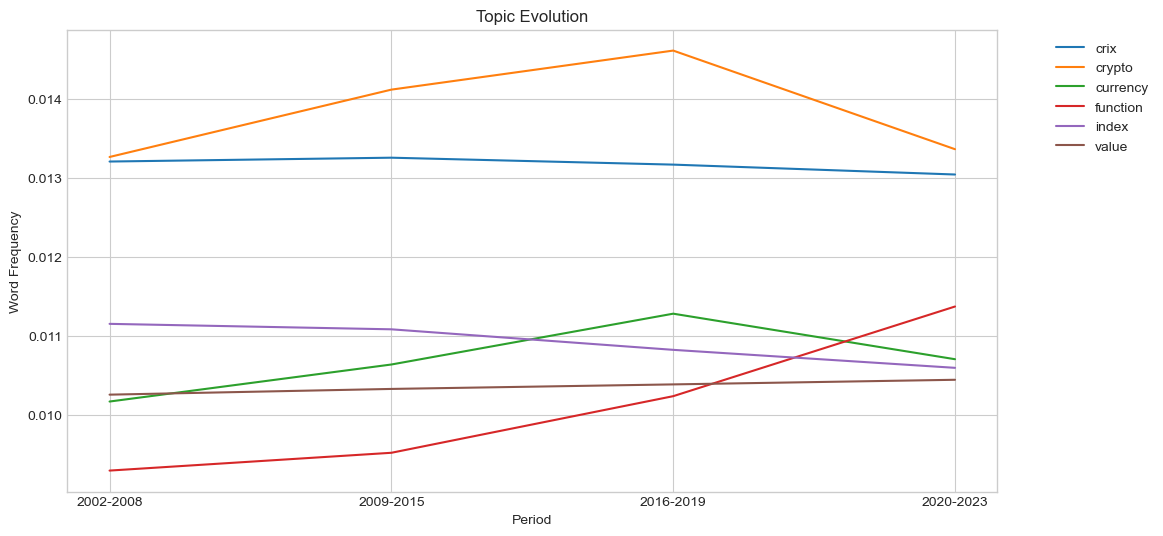

In [119]:
import matplotlib.pyplot as plt

# Plotting parameters
plt.figure(figsize=(12, 6))
plt.title('Topic Evolution')
plt.xlabel('Period')
plt.ylabel('Word Frequency')

# Iterate over each word
for word in top_k_words_topics_overtime[7].index:
    frequencies = top_k_words_topics_overtime[7].loc[word].values
    plt.plot(top_k_words_topics_overtime[7].columns, frequencies, label=word)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('plots/topic8_evolution.png')

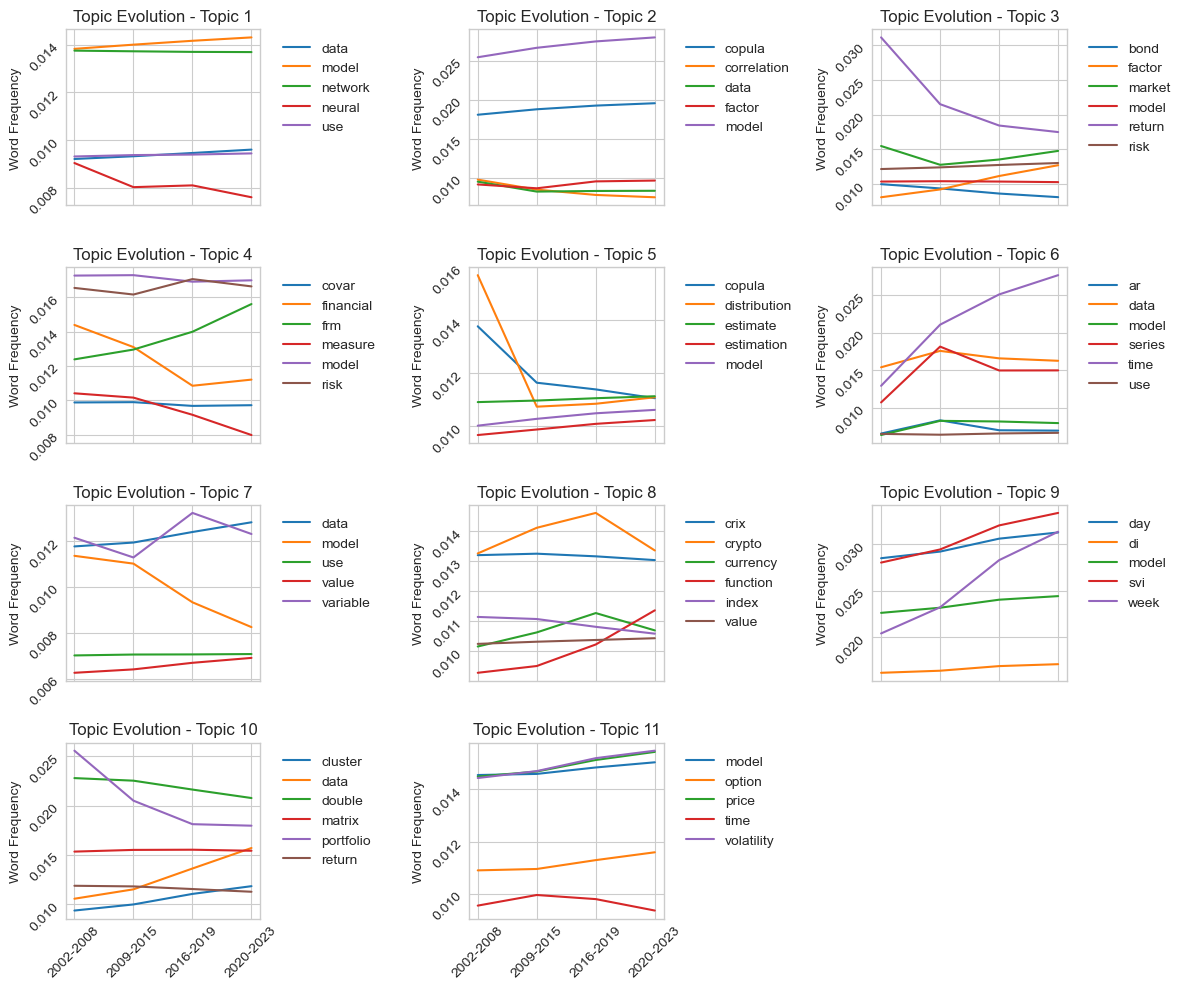

In [130]:
# Set the number of rows and columns for subplots
num_rows = 4
num_cols = 3

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 10), sharex=True)

# Reshape the axs array
axs = axs.reshape(-1)

# Iterate over each element in topics_words_time
for i, df in enumerate(top_k_words_topics_overtime):
    # Select the subplot for the current element
    ax = axs[i]

    # Plotting parameters for the current subplot
    ax.set_title(f'Topic Evolution - Topic {i+1}')
    #ax.set_xlabel('Period')
    ax.set_ylabel('Word Frequency')

    # Iterate over each word
    for word in df.index:
        frequencies = df.loc[word].values
        ax.plot(df.columns, frequencies, label=word)
    
    ax.tick_params(labelrotation=45)
    # Add legend and grid to the current subplot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True)

axs.flat[-1].set_visible(False) # to remove last plot
# Adjust spacing between subplots
plt.tight_layout()

plt.savefig('plots/topics_evolution.png')
# Show the figures
plt.show()